---
---
# Predicting COVID19 Positives Using Image Classification
This notebook will deploy various sci-kit learn models to classify chest x-ray images of people with COVID19, Pneumonia, and also healthy people. 
---
---

***
## Authorship and Resources Used
* Notebook written by Ezekial Kalmes
* Done with the assistance of some code provided by Prof. Sheese, which will be cited throughout.
* Stack Overflow was also used for help in multiple instances. The links to the pages will also be cited when they are used. 

---
## Introduction


### Background on COVID19
"COVID-19 (coronavirus disease 2019) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), a strain of coronavirus. The first cases were seen in Wuhan, China, in late December 2019 before spreading globally. The current outbreak was officially recognized as a pandemic by the World Health Organization (WHO) on 11 March 2020.

Currently Reverse transcription polymerase chain reaction (RT-PCR) is used for diagnosis of the COVID-19. X-ray machines are widely available and provide images for diagnosis quickly so chest X-ray images can be very useful in early diagnosis of COVID-19." -Prashant Patel, at https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

### Why Build A Model?
In a world full of uncertainty due to this pandemic, this model will hopefully provide doctors with a way of automatically detecting COVID in chest scans with a low false negative rate, in order to make sure everyone with COVID gets correctly diagnosed. A higher false positive rate could be seen as acceptable, as it would allow doctors to err on the side of caution when prescribing a quarantine or even deploying a vaccine. However, for people in work-driven world, being held up in quarantine due to a false positive would be a detriment to their work capabilities. In addition, Pfizer, the company deploying the vaccine, only has a certain supply that will only go to the highest-risk patients, and won't be ready for mass distribution until April 2021. Giving falsely positive persons a vaccine, even at a 5% rate, would mean a massive amount of vaccines would not be available for people who need them most. So, the ultimate question is, is using an image classification model built with xrays of healthy, pneumonia, and COVID lungs more effective in predicting whether or not someone is COVID Positive than the rapid antigen test?

***
## Data Description and Source
* The dataset I have selected is from Kaggle, and contains almost 6500 X-ray images of lungs that have been classified as either healthy, COVID positive, or pneumonia positive. The dataset is already split into test and train, which is one of the reasons why I selected it. In addition, it is one of the largest COVID X-ray databases I found, as most of the others had under 4000 images. 
* The dataset was taken from https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

* Images are collected from various publicly available resources.
Sources:

  * https://github.com/ieee8023/covid-chestxray-dataset

  * https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

  * https://github.com/agchung

***
## Ethics
* The only harm I can really think of for this analysis is the violation of HIPAA laws. I'm not really sure how these X-ray images were obtained, but I am assuming that the patients signed off to allow these X-rays to be used for research. 

***
## Import Libraries and Set Preferences for Visualization

In [ ]:
#general imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import random

# import classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import metrics for assessing classification models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

***
## Read and Verify Data


In [ ]:
# imports and functions for authenticating google account
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#id of zip file in google drive
file_id = '1VXAnY4MNDo4uIPBuavsfu26EpigiJ-UY'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
#user must download file into notebook 
downloaded.GetContentFile('COVID19_Xray_images.zip')

In [ ]:
!ls -lha COVID19_Xray_images.zip

-rw-r--r-- 1 root root 2.1G Nov 18 17:33 COVID19_Xray_images.zip


In [ ]:
#unzipping images folder
filelist = !unzip COVID19_Xray_images.zip

***
## Preparing for the Model


### X-Rays to A-rrays
BOOM! 6500 images inbound. Time to convert these JPG's into NumPy arrays so they can be put into a pandas dataframe. 

#### Training Images
This for loop will loop through all of the folders and turn the images into Image objects and then numpy arrays, while keeping track of which classification they were. It will append these arrays to their respective lists.

In [ ]:
# lists to hold the results of the loop
files_list = []
classifiers_list = []

In [ ]:
#THIS LOOP WILL TAKE A WHILE. IT IS LOOPING THROUGH 6500 IMAGES
#loops through train folder of the data via the 3 subfolders
for classification in os.listdir("/content/COVID19_Xray_images/train"):
  if classification != ".DS_Store": # avoids metadata
  # loops through train folder and splits files by the covid, pneumonia, and normal "classification" folders
    for file in os.listdir("/content/COVID19_Xray_images/train/" + classification): 
      #turns the jpg file into a PIL Image object, converts to greyscale, resizes all images to (128,128), turns into np array, flattens the array, then appends to files_list
      files_list.append(np.array(Image.open("/content/COVID19_Xray_images/train/" + classification + "/" + file).convert('L').resize((128,128))).flatten()) 
      # appends the classifiers to classifiers list 
      classifiers_list.append(classification)

In [ ]:
len(files_list)

5144

In [ ]:
len(classifiers_list)

5144

#### Testing Images
The train data is now stored in a list of NumPy arrays, now the same for the test data. This will look very similar to the process for the training images.

In [ ]:
files_list_test = []
classifiers_list_test = []

In [ ]:
#does the same as above, but instead in test data set
for classification in os.listdir("/content/COVID19_Xray_images/test"):
  if classification != ".DS_Store": 
    for file in os.listdir("/content/COVID19_Xray_images/test/" + classification): 
      files_list_test.append(np.array(Image.open("/content/COVID19_Xray_images/test/" + classification + "/" + file).convert('L').resize((128,128))).flatten())  
      classifiers_list_test.append(classification)

In [ ]:
len(files_list_test)

1288

In [ ]:
len(classifiers_list_test)

1288

Comparing the shapes of the first training image and the first test image ((605, 862) and (1816, 1650)), it is evident that all of the images are of different sizes. In terms of model accuracy, it will be important for all of the images to be the same size. PIL's Image library has a handy tool for this, .resize(), which was added into both for loops after this issue was noticed. In addition, the images will need to be greyscale, so that the arrays are not 3-dimensional. PIL's Image library also has a command for this, which is the .convert('L') command in the for loops. 

### Save The Pandas
The images have now been turned into arrays, which are stored inside files_list's. These arrays were flattened in the for loops, meaning they were taken from (128,128) and turned into (16384), which is 128x128. This will allow the lists to be turned into dataframes, as pandas only takes 1 dimensional arrays as input. 

In [ ]:
#https://stackoverflow.com/questions/49540922/convert-list-of-arrays-to-pandas-dataframe
xray_train = pd.DataFrame(list(map(np.ravel, files_list)))

In [ ]:
xray_train.shape

(5144, 16384)

Good, the number of rows in the dataframe matches the number of items in the list. Also, the number of columns matches the size of the flattened arrays (128*128=16384).

In [ ]:
classification_train = pd.DataFrame(data=classifiers_list, columns=['classifier'])
classification_train.head()

,classifier
0,PNEUMONIA
1,PNEUMONIA
2,PNEUMONIA
3,PNEUMONIA
4,PNEUMONIA
...,...
4995,NORMAL
4996,NORMAL
4997,NORMAL
4998,NORMAL


The classification_train contains all the necessary labels for the images, which will become the y_train varaible. 

In [ ]:
#https://stackoverflow.com/questions/49540922/convert-list-of-arrays-to-pandas-dataframe
xray_test = pd.DataFrame(list(map(np.ravel, files_list_test)))

In [ ]:
xray_test.shape

(1288, 16384)

Good, the number of rows in the dataframe matches the number of items in the list. Also, the number of columns matches the size of the flattened arrays (128*128=16384).

In [ ]:
classification_test = pd.DataFrame(data=classifiers_list_test, columns=['classifier'])
classification_test.head()

,classifier
0,PNEUMONIA
1,PNEUMONIA
2,PNEUMONIA
3,PNEUMONIA
4,PNEUMONIA


Let's try to print some of the X-rays out. 

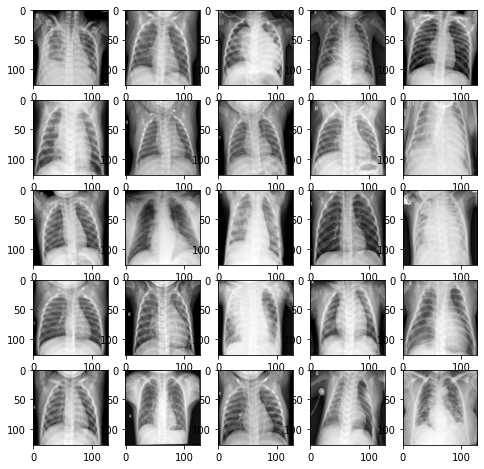

In [ ]:
# adapted from https://stackoverflow.com/a/46616645 
#taken from Prof. Sheese in exercise 12.3.1.1

columns, rows = 5, 5
fig = plt.figure(figsize = (8, 8))

for i in range(1, columns*rows +1):
  random_pic_index = random.randint(0,5143)
  fig.add_subplot(rows, columns, i)
  plt.imshow(xray_train.iloc[random_pic_index,:].to_numpy().reshape((128, 128)), cmap="gray")
plt.show()


Here we can see that while there are not labels with the classification of healthy, COVID positive, or pneumonia positive, we can fairly assume which lungs are healthy and which aren't based on the amount of white matter surrounging the lungs. Let's see if sci-kit learn can do the same. 

## Building/Evaluating the Models
Here, the xray train/test dataframes will be turned into X_test/train dataframes, and the classification dataframes will be turned into y_train/test. They will then be fit into decision tree and random forrest tree algorithms, which will then be evaluated based on accuracy. 

### Train/test Dataframes

In [ ]:
X_train = xray_train
X_train.shape

(5144, 16384)

In [ ]:
X_test = xray_test
X_test.shape

(1288, 16384)

In [ ]:
y_train = classification_train
y_train.head()

,classifier
0,PNEUMONIA
1,PNEUMONIA
2,PNEUMONIA
3,PNEUMONIA
4,PNEUMONIA


In [ ]:
y_train.value_counts()

classifier
PNEUMONIA     3418
NORMAL        1266
COVID19        460
dtype: int64

In [ ]:
y_test = classification_test
y_test.head()

,classifier
0,PNEUMONIA
1,PNEUMONIA
2,PNEUMONIA
3,PNEUMONIA
4,PNEUMONIA


### Decision Tree Classifier
With the X_train/test and y_train/test dataframes created, it's time to build the first model: a Decision Tree Classifier

#### Fitting the Model

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

#### Evaluating the Model


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     COVID19       0.85      0.76      0.80       116
      NORMAL       0.76      0.77      0.76       317
   PNEUMONIA       0.90      0.91      0.90       855

    accuracy                           0.86      1288
   macro avg       0.84      0.81      0.82      1288
weighted avg       0.86      0.86      0.86      1288



The model appears to be best at predicting whether or not a patient has pneumonia, at 90%, which makes sense, as there is more pneumonia data to train and test on. Let's see what the confusion matrix tells us about false positives/negatives.

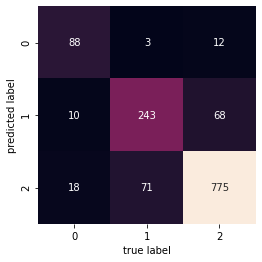

In [ ]:
# from https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
# from Prof. Sheese, in exercise 12.3.1.1
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

As this confusion matrix shows, there was a very low false positivity rate for COVID, as only ~1% (15/1288) of the chest scans were falsely classified as positive, 3 of which being healthy lungs, 12 of which having pneumonia. The larger issue is with false negatives, as ~24% (28/116) of the COVID positive lungs were predicted to be negative when in reality they were positive. 

#### Visualizing the Tree
This is going to create a visualtion of the tree that the dtc creates, with the gini index, number of samples, and value thresholds. 

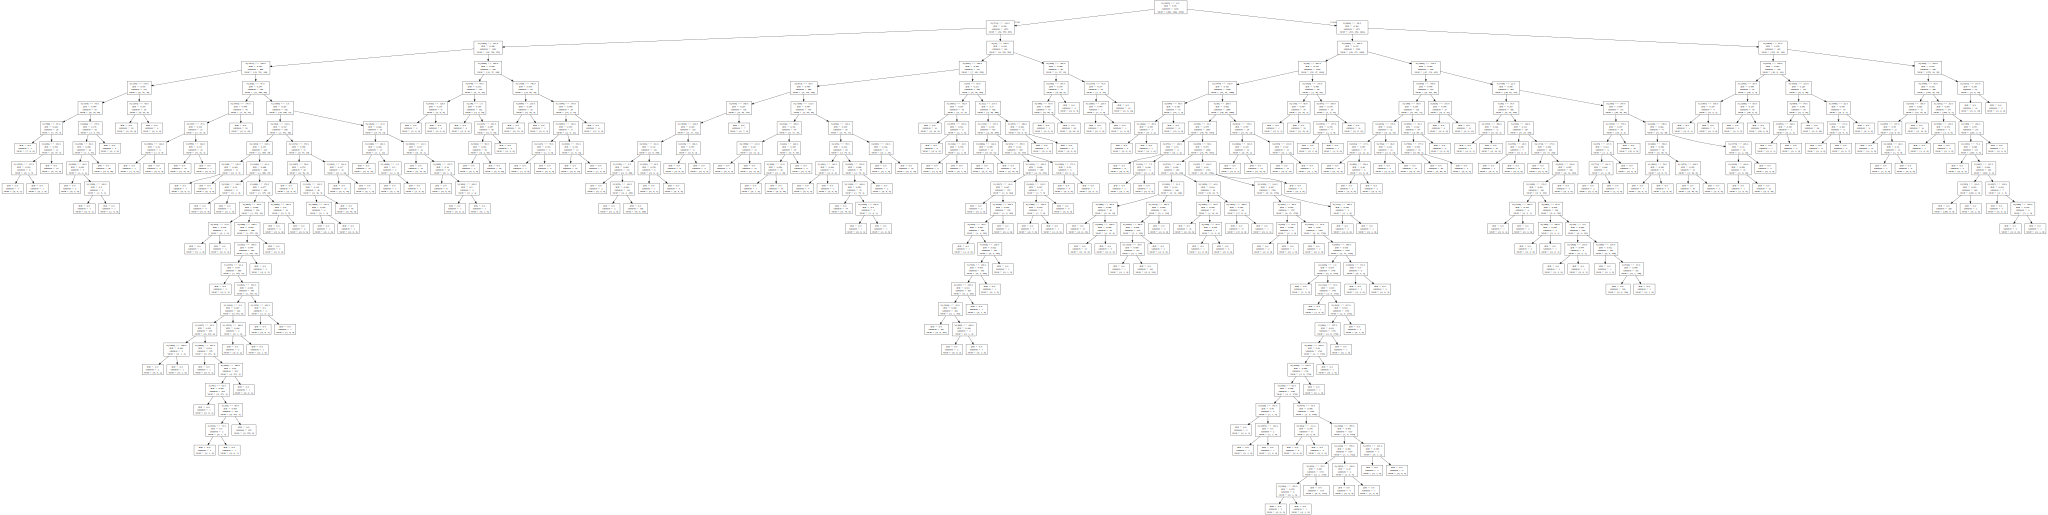

In [ ]:
# taken from Prof. Sheese, exercise 12.3.1.1
import graphviz

display(graphviz.Source(tree.export_graphviz(dtc)))

### Random Forest Classifier
Here, the X_train/test and y_train/test dataframes will be fit into a Random Forest Classifier, and then evaluated based on accuracy. 

#### Fitting the Model

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


#### Evaluating the Model

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     COVID19       0.96      0.84      0.89       116
      NORMAL       0.91      0.85      0.88       317
   PNEUMONIA       0.94      0.97      0.95       855

    accuracy                           0.93      1288
   macro avg       0.93      0.89      0.91      1288
weighted avg       0.93      0.93      0.93      1288



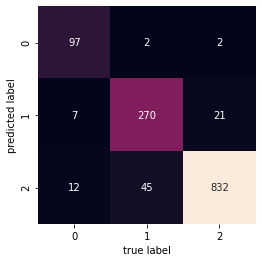

In [ ]:
# from https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

The Random Forest does much better than the Decision Tree based on their f1 scores as well as their false positivity/negativity rates. The RFC only has a ~0.3% (4/1288) false positivity rate, and the false negativity rate falls to ~16% (19/116). 

***
## Conclusions
* In conclusion, when looking at the Random Forest Classifier (as it performed better), the resulting false positivity rate was ~0.3%, and the false negativity rate is ~16%. According to an article on Harvard University's health Blog, written by Robert H. Shmerling, MD, the false positivity for rapid antigen testing hovers right around 0% as well, with only a few cases having been reported as falsely positive. Where it gets interesting is in the false negativity rate. It has been reported as being as high as *50%*, which is ludicrously high compared to the ~16% false negativity rate which is given by the Random Forest Classifier. So, in terms of rapid alternatives to PCR tests which make take up to a week plus for results, using a Random Forest Classifier on the Xray taken of your lungs is a faster and more effective method for predicting COVID19 Positives. 

* Source: https://www.health.harvard.edu/blog/which-test-is-best-for-covid-19-2020081020734
